In [1]:
import pandas as pd
import qe.myqengine as qe

In [4]:
univ = qe.IdUniverse(ids= ['AAPL-US'])
calc = qe.Calculation(universe=univ,dates = qe.TimeSeries(start_date = '0D'),formulas =[qe.QuantFqlExpression(expr='P_OPT_OPTION_CHAIN(#DATE)',name = 'opt_chain',is_array_return_type=True,source='FqlExpression')])
calc.query()
calc.data

,DATE,UNIVERSE,opt_chain
0,20230831,AAPL-US,"[AAPL.US#C045P, AAPL.US#C0FVT, AAPL.US#C17SD, ..."


In [5]:
df = calc.data.rename(columns = {
                          'DATE':'date',
                          'UNIVERSE':'symbol'})

In [6]:
df = df.set_index(['date','symbol'])

In [7]:
#expand out options chain and reindex by date,option id
df_opts= pd.DataFrame(df.opt_chain.explode().reset_index()).set_index(['date','opt_chain'])
df_opts

symbol
date     opt_chain             
20230831 AAPL.US#C045P  AAPL-US
         AAPL.US#C0FVT  AAPL-US
         AAPL.US#C17SD  AAPL-US
         AAPL.US#C1YCP  AAPL-US
         AAPL.US#C281K  AAPL-US
...                         ...
         AAPL.US#PVGJ9  AAPL-US
         AAPL.US#PVMHW  AAPL-US
         AAPL.US#PXDM7  AAPL-US
         AAPL.US#PXTLC  AAPL-US
         AAPL.US#PY34Q  AAPL-US

[1902 rows x 1 columns]

In [9]:
#option univ
opt_univ = qe.IdUniverse(df_opts.index.get_level_values(1).to_list())

data_dict = {"style":'P_OPT_STYLE(#DATE)',
             "call_or_put_flag":'P_OPT_CALL_OR_PUT(#DATE)',
             "exp_date":'P_OPT_EXP_DATEN(#DATE)',
             "price":'P_OPT_CLOSE_PRICE(#DATE)',
             "strike_price":'P_OPT_STRIKE_PRICE(#DATE)',
             "impl_vol":'P_OPT_IMPV(#DATE)'}
# create a FQL object
fql_req = qe.Calculation(universe=opt_univ,
                        dates = qe.TimeSeries(start_date = '0D'),
                        source = 'FqlExpression',
               data_dict=data_dict)

fql_req.query()
fql_req.data

,DATE,UNIVERSE,style,call_or_put_flag,exp_date,price,strike_price,impl_vol
0,20230831,AAPL.US#C045P,0.0,0.0,20240119.0,0.13,260.0,21.824203
1,20230831,AAPL.US#C0FVT,0.0,0.0,20240119.0,65.58,125.0,40.495293
2,20230831,AAPL.US#C17SD,0.0,0.0,20240119.0,88.62,95.0,53.060256
3,20230831,AAPL.US#C1YCP,0.0,0.0,20230915.0,0.01,250.0,48.218016
4,20230831,AAPL.US#C281K,0.0,0.0,20230915.0,0.02,230.0,36.558647
...,...,...,...,...,...,...,...,...
1897,20230831,AAPL.US#PVGJ9,0.0,1.0,20230908.0,0.00,212.5,45.510596
1898,20230831,AAPL.US#PVMHW,0.0,1.0,20231013.0,0.00,250.0,67.596758
1899,20230831,AAPL.US#PXDM7,0.0,1.0,20230915.0,0.00,212.5,43.233227
1900,20230831,AAPL.US#PXTLC,0.0,1.0,20231013.0,0.00,240.0,59.721253


In [10]:
df_f = fql_req.data

In [11]:
df_f = df_f.rename(columns ={"DATE":'date',
                            "UNIVERSE":'opt_chain',})

In [12]:
#join parent tickers
df_final = df_f.set_index(['date','opt_chain']).join(df_opts['symbol'], how = 'left')

df_final.tail(10)

style  call_or_put_flag    exp_date  price  \
date     opt_chain                                                   
20230831 AAPL.US#PRXM6    0.0               1.0  20231013.0   0.12   
         AAPL.US#PT22Y    0.0               1.0  20231013.0   0.00   
         AAPL.US#PT30P    0.0               1.0  20231013.0   0.07   
         AAPL.US#PTSK7    0.0               1.0  20231013.0   8.31   
         AAPL.US#PV7DG    0.0               1.0  20231013.0  12.30   
         AAPL.US#PVGJ9    0.0               1.0  20230908.0   0.00   
         AAPL.US#PVMHW    0.0               1.0  20231013.0   0.00   
         AAPL.US#PXDM7    0.0               1.0  20230915.0   0.00   
         AAPL.US#PXTLC    0.0               1.0  20231013.0   0.00   
         AAPL.US#PY34Q    0.0               1.0  20231013.0   0.27   

                        strike_price   impl_vol   symbol  
date     opt_chain                                        
20230831 AAPL.US#PRXM6         140.0  40.223432  AAPL-US  
         AAPL.US#PT22Y         205.0  30.622425  AAPL-US  
         AAPL.US#PT30P         135.0  43.042785  AAPL-US  
         AAPL.US#PTSK7         195.0  20.567783  AAPL-US  
         AAPL.US#PV7DG         200.0  19.960178  AAPL-US  
         AAPL.US#PVGJ9         212.5  45.510596  AAPL-US  
         AAPL.US#PVMHW         250.0  67.596758  AAPL-US  
         AAPL.US#PXDM7         212.5  43.233227  AAPL-US  
         AAPL.US#PXTLC         240.0  59.721253  AAPL-US  
         AAPL.US#PY34Q         155.0  54.013895  AAPL-US

C:\Users\nurciuoli\AppData\Local\Temp\3\ipykernel_21020\2870108128.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_final[df_final['symbol']=='AAPL-US'].groupby(['exp_date','call_or_put_flag']).median()['impl_vol'].unstack().plot()


<Axes: xlabel='exp_date'>

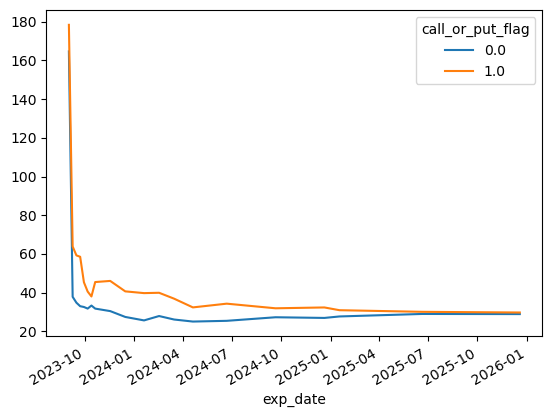

In [14]:
#convert date to datetime
df_final['exp_date'] = pd.to_datetime(df_final['exp_date'], format='%Y%m%d')
#plot CAT
df_final[df_final['symbol']=='AAPL-US'].groupby(['exp_date','call_or_put_flag']).median()['impl_vol'].unstack().plot()